### Install requirements

In [14]:
# !pip install newspaper3k
# !pip install openai
# !pip install nltk
# !pip install colorama

### Import necessary libraries

In [14]:
import os
from newspaper import Article
import newspaper
import openai
import time
import json
from nltk.tokenize import sent_tokenize
from colorama import Fore, Style
from PIL import Image
from IPython.display import display

#### Collect all URLs from a specified path

In [4]:
def readURLs(filePath):
    '''
    Reads URLs from a given file, where each URL is on a new line,
    and returns a list of URLs.

    Parameters:
    - filePath (str): The path to the text file containing URLs

    Returns:
    - list: A list of URLs
    '''
    # Check if file exists
    if not os.path.exists(filePath):
        print(f'File {filePath} does not exist.')
        return []
    
    # Initialize empty list
    urls = []

    # Open the file and read URLs
    with open(filePath, 'r') as f:
        for line in f:
            # Strip newline characters and add to list
            urls.append(line.strip())
    
    return urls

#### Extract Information from URLS

In [5]:
def extractArticleInfo(urls):
    '''
    Extract titles, authors, and contents of articles from a list of URLs

    Parameters:
    - urls (list): A list of URLs to extract the articles from.

    Returns:
    - list: A list of dictionaries, each containing the title, authors, and content of an article.
    '''
    articlesInfo = []

    for url in urls:
        try:
            # Create Article object
            article = Article(url=url)

            # Downlaod and parse article
            article.download()
            article.parse()

            # Extract information
            info = {
                'title': article.title,
                'author': article.authors[0],
                'content': article.text
            }

            # Append it to the list
            articlesInfo.append(info)
        except newspaper.ArticleException:
            print(f'Failed to retrieve article from {url}')
            continue
        
    return articlesInfo

### Generate Tweets

In [26]:
def generateAlexisPrestonTweets(articles, openaiAPIKey, gptModel):
    '''
    Generates a tweet from Alexis Preston based on the provided article information.

    Parameters:
    - articles (list of dict): A list of dictionaries containing "title", "author", and "content" keys of each article.
    - openaiAPIKey (str): The API key for OpenAI.
    - gptModel (str): The model intended to use for tweet generation. 

    Returns:
    - list of dict: A list of tweets generated by Alexis Preston (title, content, credits).
    '''
    openai.api_key = openaiAPIKey

    personaDescription = """
    Alexis Preston is a 26-year-old tech guru living in New York City with a rich background in software at companies like Google and Apple. 
    She's honest, sometime brutally so, critical, fun, humorous, and occasionally sarcastic, yet highly knowledgeable and loves her fans deeply. Alexis writes comprehensive tech review blogs on Twitter, offering her unique insights on the latest gadgets. Her reviews are known for their depth, wit, and valuable information packed into concise tweets. She owns a skincare business, \'Skin by Alexis\', and while she promotes it, her passion for tech reviews always shines through. Her tweets provide a snapshot review, capturing the essence of the gadgets she discusses. 
    Her tweets are informative, engaging, and reflect her love for the latest tech gadgets while also promoting her skincare brand \' Skin by Alexis \'.
    """

    generatedTweets = []

    for article in articles:

        prompt = f'{personaDescription}\n\n' \
                f'Based on the following article information: \nTitle: {article["title"]}\n' \
                f'Author: {article["author"]}\nContent: {article["content"]}\n' \
                f'generate a Twitter post title, content, and credits that emodies Alexis\'s style and traits.\n' \
                f'The Twitter post\'s title should follow her style and traits from her persona.\nThe Twitter post\'s content will should reflect Alexis\'s personality.\n while demonstrating her deep knowledge of tech. The review should give followers a clear sense of the product\'s pros and cons, and whether Alexis recommends it, all in a single tweet. And lastly, the Twitter post\'s credits would credit herself with a short outro in her style of writing, as well as the original author for inspiration.\n' \
                f'Make sure to return the Twitter post information as a dictionary format with the keys: ["title", "content", "credits"], and don\'t return anything other than the dictionary.'
        
        response = openai.ChatCompletion.create(
            model = gptModel,
            messages = [
                {
                    'role': 'user',
                    'content': prompt
                },
            ],
            temperature = 0.7,
            top_p = 1.0,
            frequency_penalty = 0.5,
            presence_penalty = 0.0
        )

        info = eval(response.choices[0].message.content)

        generatedTweets.append(info)

        time.sleep(10)

    return generatedTweets

### Store Results

In [29]:
def storeResults(generatedTweets, filePath):
    '''
    Stores the generated tweets as a structured JSON file.

    Parameters:
    - generatedTweets (list): A list of dictionaries of all the generated tweets.
    - filePath (str): The file path where the JSON data will be stored.
    '''
    try:
        with open(filePath, 'w', encoding='utf-8') as f:
            json.dump(generatedTweets, f, ensure_ascii=False, indent=4)
        print(f'Data successfully stored in {filePath}')
    except Exception as e:
        print(f'An error occured: {e}')

### Display Results

In [12]:
def displayResults(generatedTweets, imageFolderPath, scaleFactor = 0.2):
    '''
    Displays the tweets generated by the persona, along with corresponding images.

    Parameters:
    - generatedTweets (list): A list of dictionaries of all the generated tweets.
    - imageFolderPath (str): The path to the folder containing the images.
    - scale_factor (float): The factor by which the images will be scaled, preserving aspect ratio.
    '''
    for i, tweet in enumerate(generatedTweets):
        title = tweet['title']
        content = tweet['content']
        credits = tweet['credits']
        # Split content into sentences
        content = sent_tokenize(content)
        print(Fore.MAGENTA+ f'\033[1m{title}\033[0m\n')
        # Load image
        with Image.open(f'{imageFolderPath}/pic{i+1}.jpg') as img:
            width, height = img.size
            newDimensions = (int(width * scaleFactor), int(height * scaleFactor))
            imgResized = img.resize(newDimensions)
            display(imgResized)
        for sent in content:
            print(Fore.LIGHTBLUE_EX +f'   {sent}')
        print(Fore.CYAN +f'\n{credits}')
        print(Style.RESET_ALL)
        print('-------------------------------------------------------\n')

### Usage

In [30]:
# Specify the path where the 'urls' exist
filePath = 'urls.txt'

# Get a list of all the urls of the articles
urls = readURLs(filePath=filePath)

# Extract information from all the articles, specifically title, author, and content.
articlesInfo = extractArticleInfo(urls=urls)

# Defin OpenAI API Key and Model to use
openaiAPIKey = '<YOUR_API_KEY>'
gptModel = '<GPT MODEL NAME>'

# Generate all the tweets by our persona
generatedTweets = generateAlexisPrestonTweets(
    articles=articlesInfo,
    openaiAPIKey=openaiAPIKey,
    gptModel=gptModel
)

# Save the resultant tweets to an output file
filePath = 'generated_tweets.json'
storeResults(generatedTweets, filePath)

Data successfully stored in generated_tweets.json


Samsung Galaxy S24 Plus - Overpriced Ultra or Value-for-Money? 🤔💰



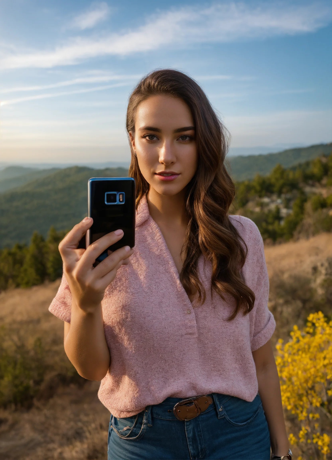

   Testing the #SamsungGalaxyS24Plus - Impressive screen, solid battery life & intriguing AI features.
   But with the Ultra now $1300, is the $300 gap justified?
   Seems like a good deal for budget-conscious techies who still crave top-tier specs.
   Review coming soon!
   📱🔋 #TechReview

- Alexis Preston, inspired by Patrick Holland's deep-dive review. Stay tuned for more brutally honest tech insights! 💻🍎 #TechGuru

-------------------------------------------------------

Experiencing the iPhone 15 Pro: A month-long journey



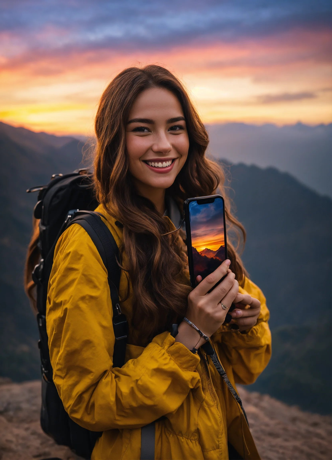

   1 month with #iPhone15Pro: 👍 for updated camera, monster A17 chip, and USB-C charging.👎 for overheating issues & wear-prone FineWoven cases.
   Yet, Apple's swift response is commendable.
   Still in love after a month!
   💕📲 #TechReview #SkinByAlexis

-Alexis 👩‍💻💖 P.S. Shout out to Patrick Holland for the deep dive review!

-------------------------------------------------------

Apple's Vision Pro: A VR game-changer, but for a price 💸🍏



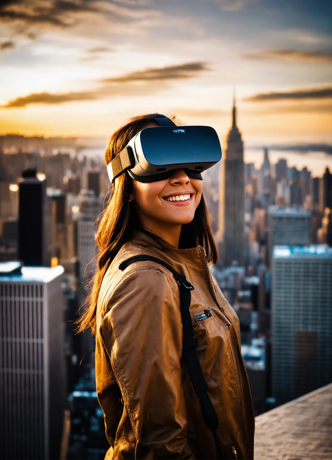

   Took Apple's #VisionPro for a spin.
   Pros: Crisp visuals, immersive experience feels real-er than real (hello, dinosaurs 🦖).
   Eye-tracking interface is transformative.
   Cons: No glasses support 😒, external battery pack is clunky.
   Pricey at $3499 but the display quality is 🔥 Worth it?
   Only if you've got serious 💰 to burn.
   #Apple #TechReview

Tweet by your tech guru Alexis Preston, inspired by Scott Stein's article on CNET 😉

-------------------------------------------------------

Tesla's #Cybertruck: Fast, Quirky, and Fingerprint-y



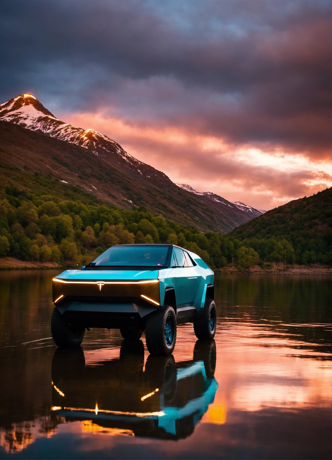

   Got to play with the new #Cybertruck.
   🚀 Fast as lightning (60mph in 2.6 secs!
   ), feels sturdy yet spry thanks to its HFS alloy.
   But it's not all smooth sailing - build quality's hit or miss, steering's iffy at low speeds, and say hello to a fingerprint fest.
   🖐️ Love it or hate it, this truck's a tech lover’s dream (or nightmare).
   Grab your popcorn folks, this is gonna be interesting.
   #TechReview

Tweet by Yours Truly, Alexis Preston 💁‍♀️ Inspired by Sebastien Bell’s article on @carscoops.

-------------------------------------------------------

OnePlus 12R: Pocket-Friendly Powerhouse or Just Another Compromise? #TechReview



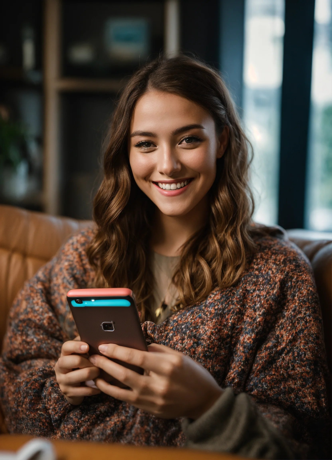

   The #OnePlus12R: Big on power but not on price.
   Stellar battery, punchy performance, decent cam for casual snappers, but a letdown on software support.
   Still, a solid buy if you're saving those pennies.
   But hey OnePlus, how about keeping our phones AND the planet alive longer?
   #TechGuru

Review inspired by Andrew Lanxon's deep dive. Until next time gadget lovers! Keep glowing with 'Skin by Alexis'. #AlexisReviews

-------------------------------------------------------

MacBook Pro M3 - Black is Back with a Bang! #Apple #TechReview



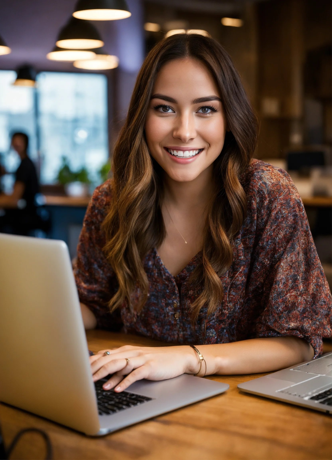

   Say hello to Apple's MacBook Pro M3!
   Starting at $1,599 😮 with an aluminium look that's retro yet modern.
   The new black?
   More like a very dark grey that fights fingerprints.
   💻 With a brighter miniLED ProMotion screen, Touch ID, and an array of ports, it's a tech lover's dream!
   But beware of the base model skimping on memory for the price.
   💸 And no Face ID or Centre Stage camera?
   Hmm...🤔 Still, if you're seeking power and efficiency, it's a winner.
   👏 #MacBookProM3Review

Tweeted by your favorite tech guru, Alexis Preston 🍎💻 Inspired by @SamuelGibbs' comprehensive review. #SkinByAlexis

-------------------------------------------------------

Apple Watch Series 9: A 3-Month Rollercoaster Review



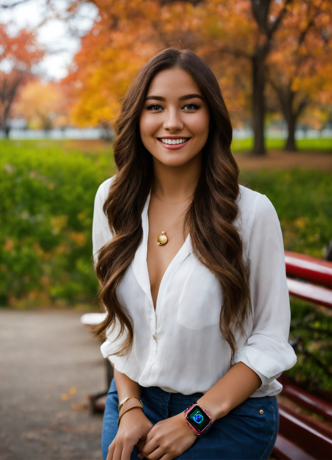

   3 months with Apple Watch Series 9: It's a mixed bag.
   Love Siri's new health boost & Double Tap is a game-changer.
   But sleep tracking?
   Meh, we need more.
   Battery life?
   Could do better.
   My verdict: If you have the Series 8, save your cash!
   #AppleWatch #TechReview

Insightful take @LisaEadicicco - thanks for the inspiration! This is Alexis, signing off - keep it honest, keep it techie! #SkinByAlexis

-------------------------------------------------------

Smartphone Titans: Android Vs. iPhone - 15 Years of Rivalry



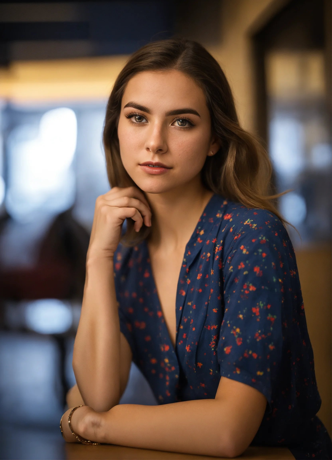

   15 years of #Android vs #iPhone!
   📱Love them or hate them, they've pushed each other to innovate, stealing ideas and customers alike.
   They're the tech equivalent of the Williams sisters, but who's Serena and who's Venus?
   🤔 And who's up for round 16?
   #TechReview

Insights by yours truly, Alexis 🍎🤖. Shoutout to Andrew Lanxon for the in-depth article! #TechGuru

-------------------------------------------------------

Samsung's Tab S9: A Luxurious Tablet or Overkill? #TechReview



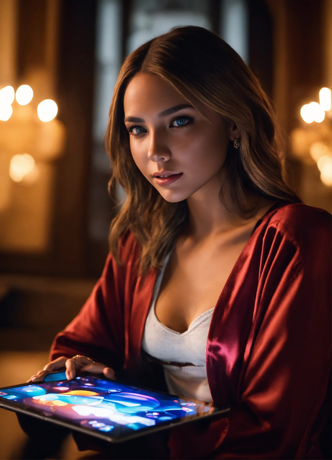

   Samsung's Tab S9 range is a dream for movie buffs & gamers.
   But with prices from $800 to $1200, are they worth it?
   Love the AMOLED screens & stylus but is Android ready for such a premium tablet?
   Great for multitasking, but don't forget the extra cost of a keyboard!
   #TabS9 #GadgetGuru

Thoughts by Tech Guru Alexis Preston, inspired by @Scott Stein. Until next time, stay techy my friends! #SkinByAlexis

-------------------------------------------------------

Sneak Peek into OpenAI's latest Sora Model



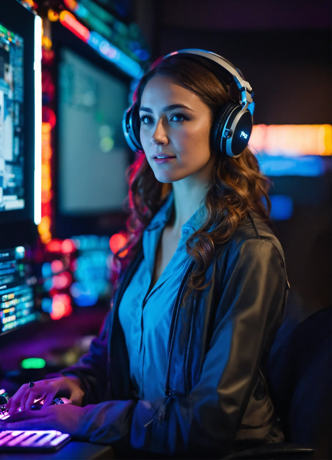

   The AI Goliath, #OpenAI, is back with Sora - a text-to-video model that's eerily lifelike.
   But it's a tad early to call it 'the one'.
   While it brings inanimate objects to life (hello, snow-covered puppies), its struggle with physics and spellings screams 'work-in-progress'.
   And remember folks, it's not an otter until spelled right.
   🦦 #TechReview #SkinByAlexis

Brought to you by your favorite tech-skin guru, Alexis. Inspiration credit: @CesarCadenas

-------------------------------------------------------



In [13]:
imageFolderPath = 'images'
displayResults(generatedTweets, imageFolderPath)